# Setup

In [1]:
# To run 3d interactive plots
# conda install -c conda-forge ipympl
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib

# Functions

In [4]:
%matplotlib widget

import pickle

from cflib.localization import LighthouseBsGeoEstimator
from cflib.crazyflie.mem import LighthouseBsGeometry

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


def plot_bs_geometries(g):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(-2, 2)
    ax.set_ylim3d(-2, 2)
    ax.set_zlim3d(0, 2)
    
    # Plot base station geoms
    for bs_id, bs_g in g.items():
        
        point = (bs_g.origin[0], bs_g.origin[1], bs_g.origin[2])
        ax.scatter(*point, marker='o', s=100)
        ax.text(point[0], point[1], point[2] + 0.1, bs_id, size=20, zorder=1)
    
    # Plot CF geom
    ax.scatter(0, 0, 0, marker="D", s=50)
    ax.text(0, 0, 0.1, "CF", size=20, zorder=1)
    
    # Plot CF axes
    # X
    ax.plot3D([0, 0.5], [0, 0], [0, 0], 'red')
    # Y
    ax.plot3D([0, 0], [0, 0.5], [0, 0], 'green')
    # Z
    ax.plot3D([0, 0], [0, 0], [0, 0.5], 'blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    

def get_bs_geometry_from_sensor_data(sensor_data_path):
    upways = pickle.load(open(sensor_data_path, "rb"))
    bs_poses = run_get_bs_geometry_proxy(upways)
    return bs_poses


def run_get_bs_geometry_proxy(sensor_vectors_all):

    estimator = LighthouseBsGeoEstimator()
    geometries = {}

    for id in sorted(sensor_vectors_all.keys()):
        average_data = sensor_vectors_all[id]
        sensor_data = average_data[1]
        rotation_bs_matrix, position_bs_vector = estimator.estimate_geometry(
            sensor_data)
        is_valid = estimator.sanity_check_result(position_bs_vector)
        if is_valid:
            geo = LighthouseBsGeometry()
            geo.rotation_matrix = rotation_bs_matrix
            geo.origin = position_bs_vector
            geo.valid = True

            geometries[id] = geo

        else:
            print("Warning: could not find valid solution for " + id + 1)

    return geometries

# Analysis

## CF in regular position

In [5]:
upways_data_path = "sensor_data_1614655937013395.pickle"
u = get_bs_geometry_from_sensor_data(upways_data_path)
plot_bs_geometries(u)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Appears to correctly calculate the positions of the base stations

## CF in sideways position

In [6]:
sideways_data_path = "sensor_data_1614655377286432.pickle"
s = get_bs_geometry_from_sensor_data(sideways_data_path)
plot_bs_geometries(s)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In the above plot, the red and blue (X and Y) axes map out the real world floor. Comparing this to our actual base station locations, we can see that base station 1 appears to be in the wrong position, mirrored in the Y axis.

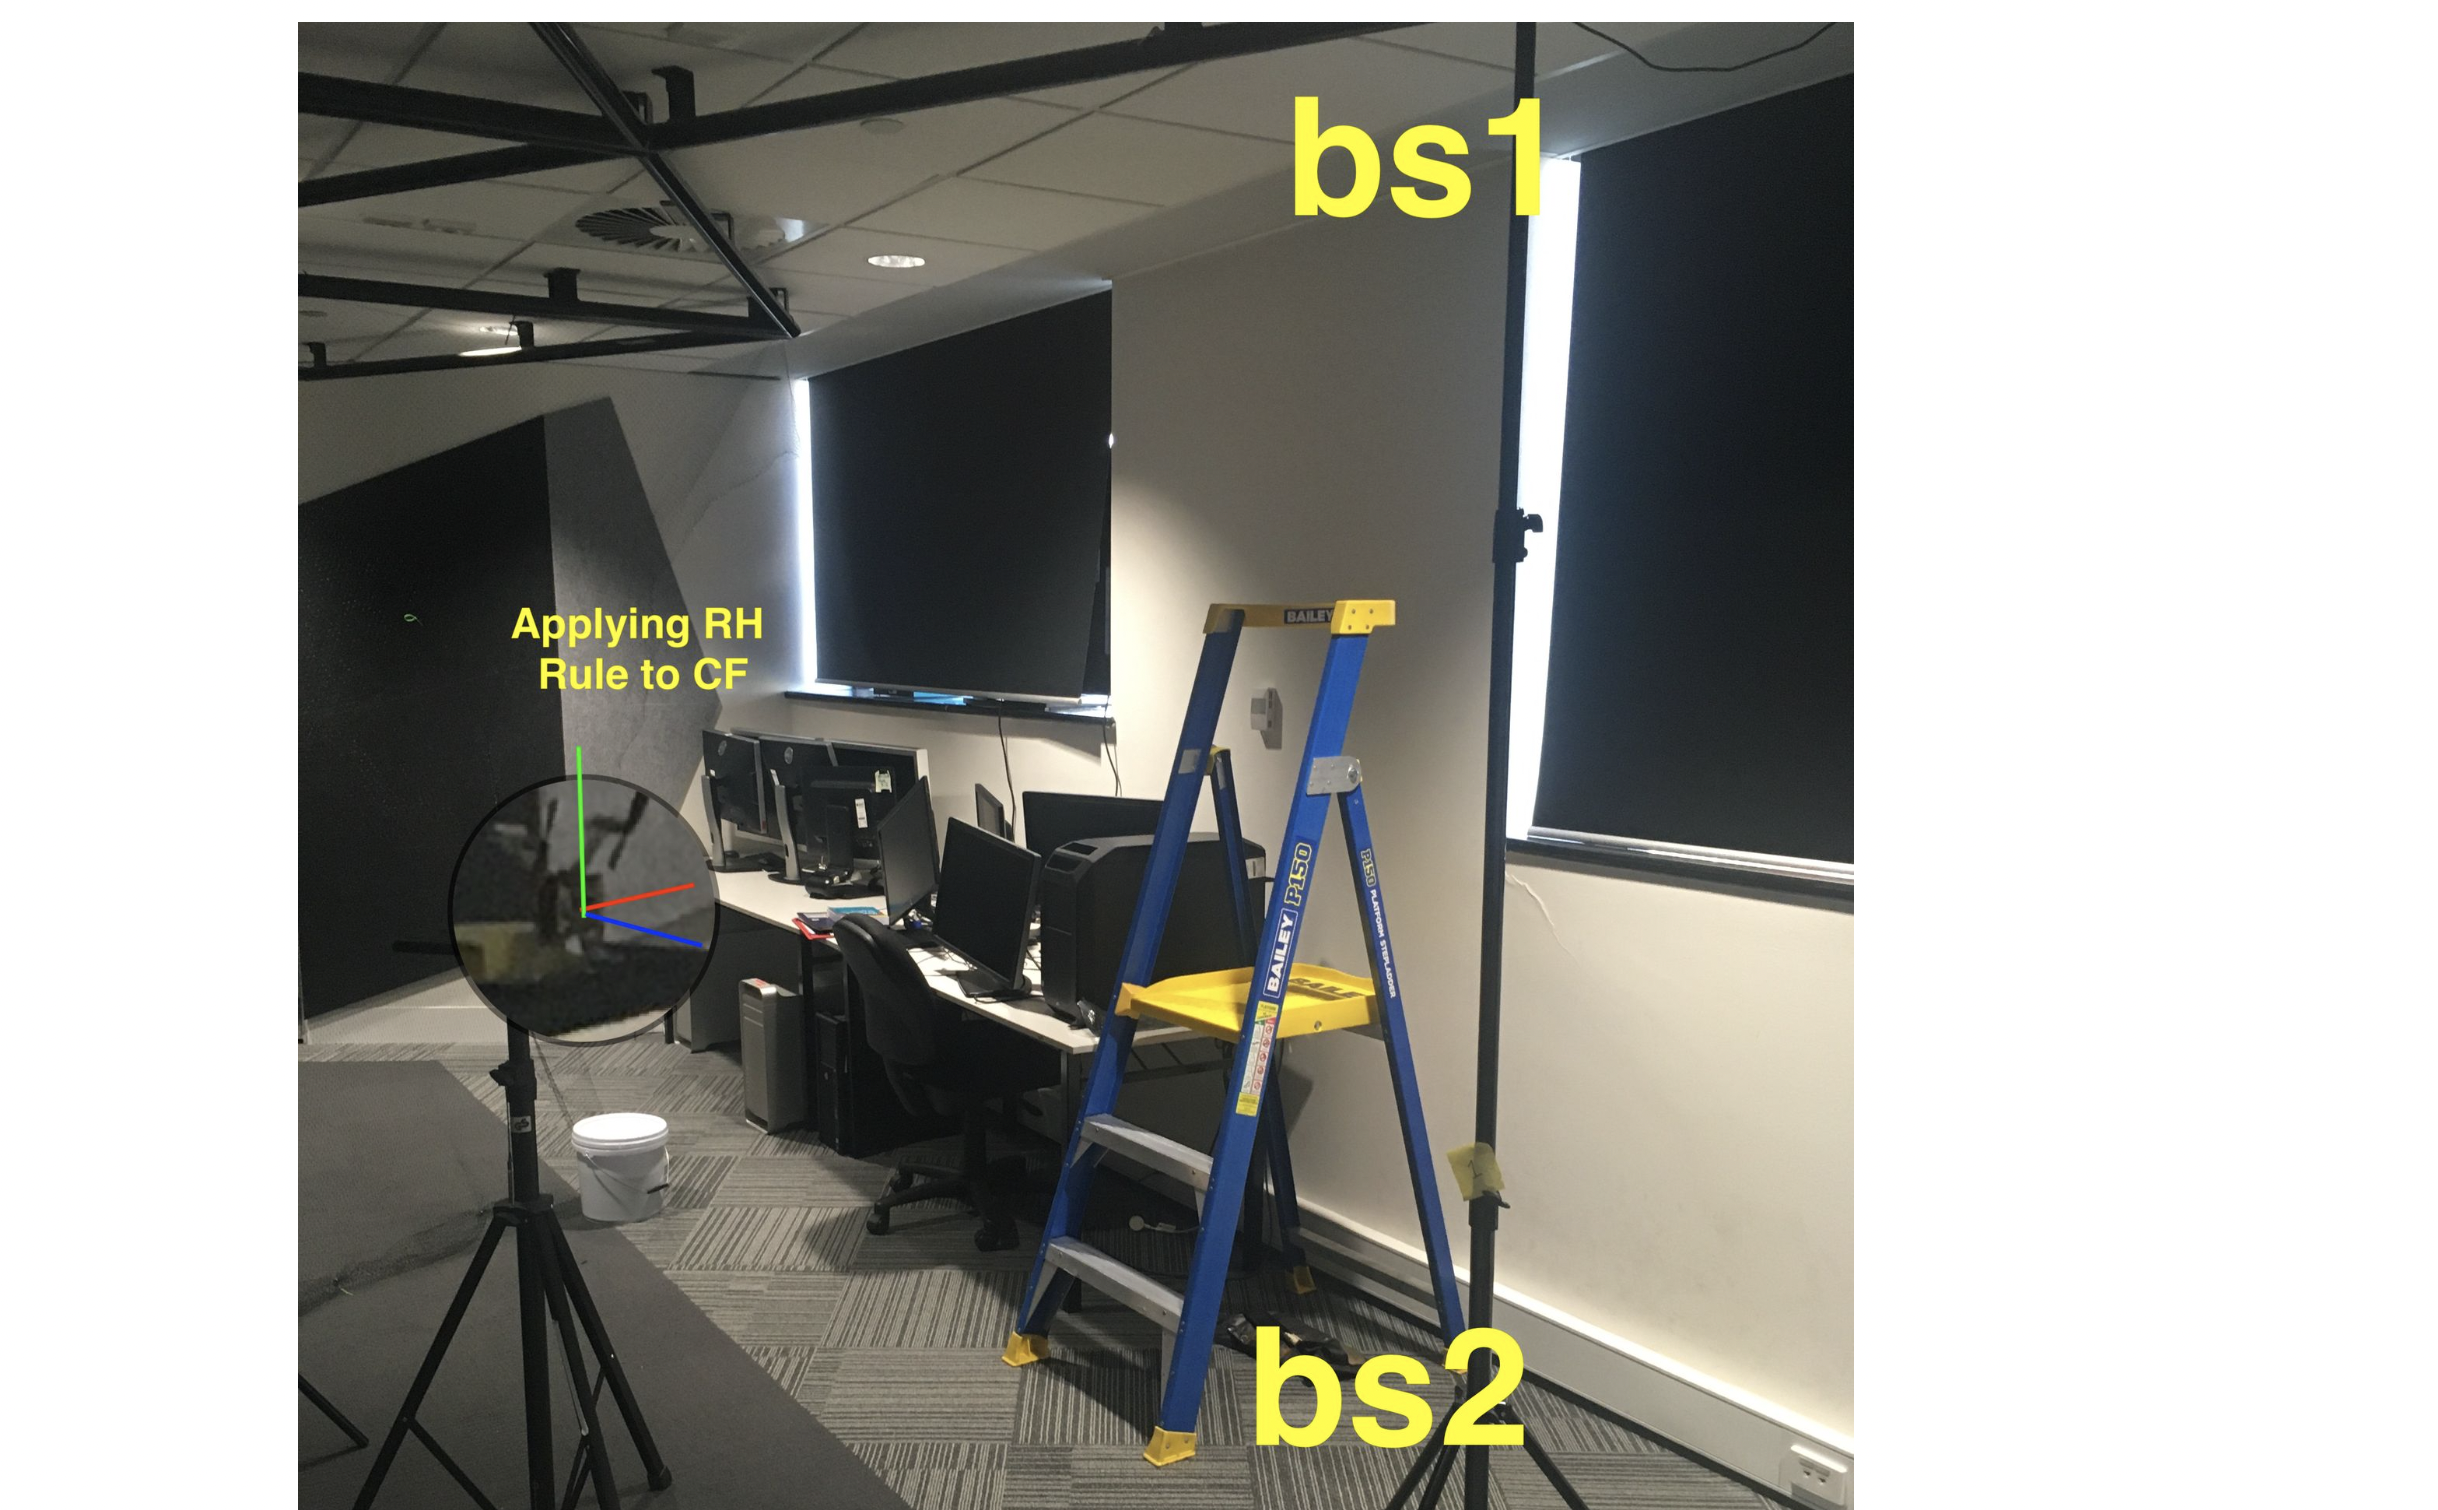

What's causing this? Let's take a look at what the `get_bs_geometry` code is doing:

#### (1) Iterate through the sensor data for each base station
- The sensor data for each base station (BS) is a list of 4 `LighthouseBsVector` objects which specify vectors to the 4 sensors on the CF
- These vectors are in the BS reference frame
- Each of the 4 vector objects has the following two terms, which are used by the subsequent steps:
    - `lh_v1_horiz_angle`: the horizontal sweep angle from the BS' perspective
    - `lh_v1_vert_angle`: the vertical sweep angle from the BS' perspective
- An illustration of these is below, where the `lh_v1_horiz_angle` and `lh_v1_vert_angle` to sensor 3 are shown

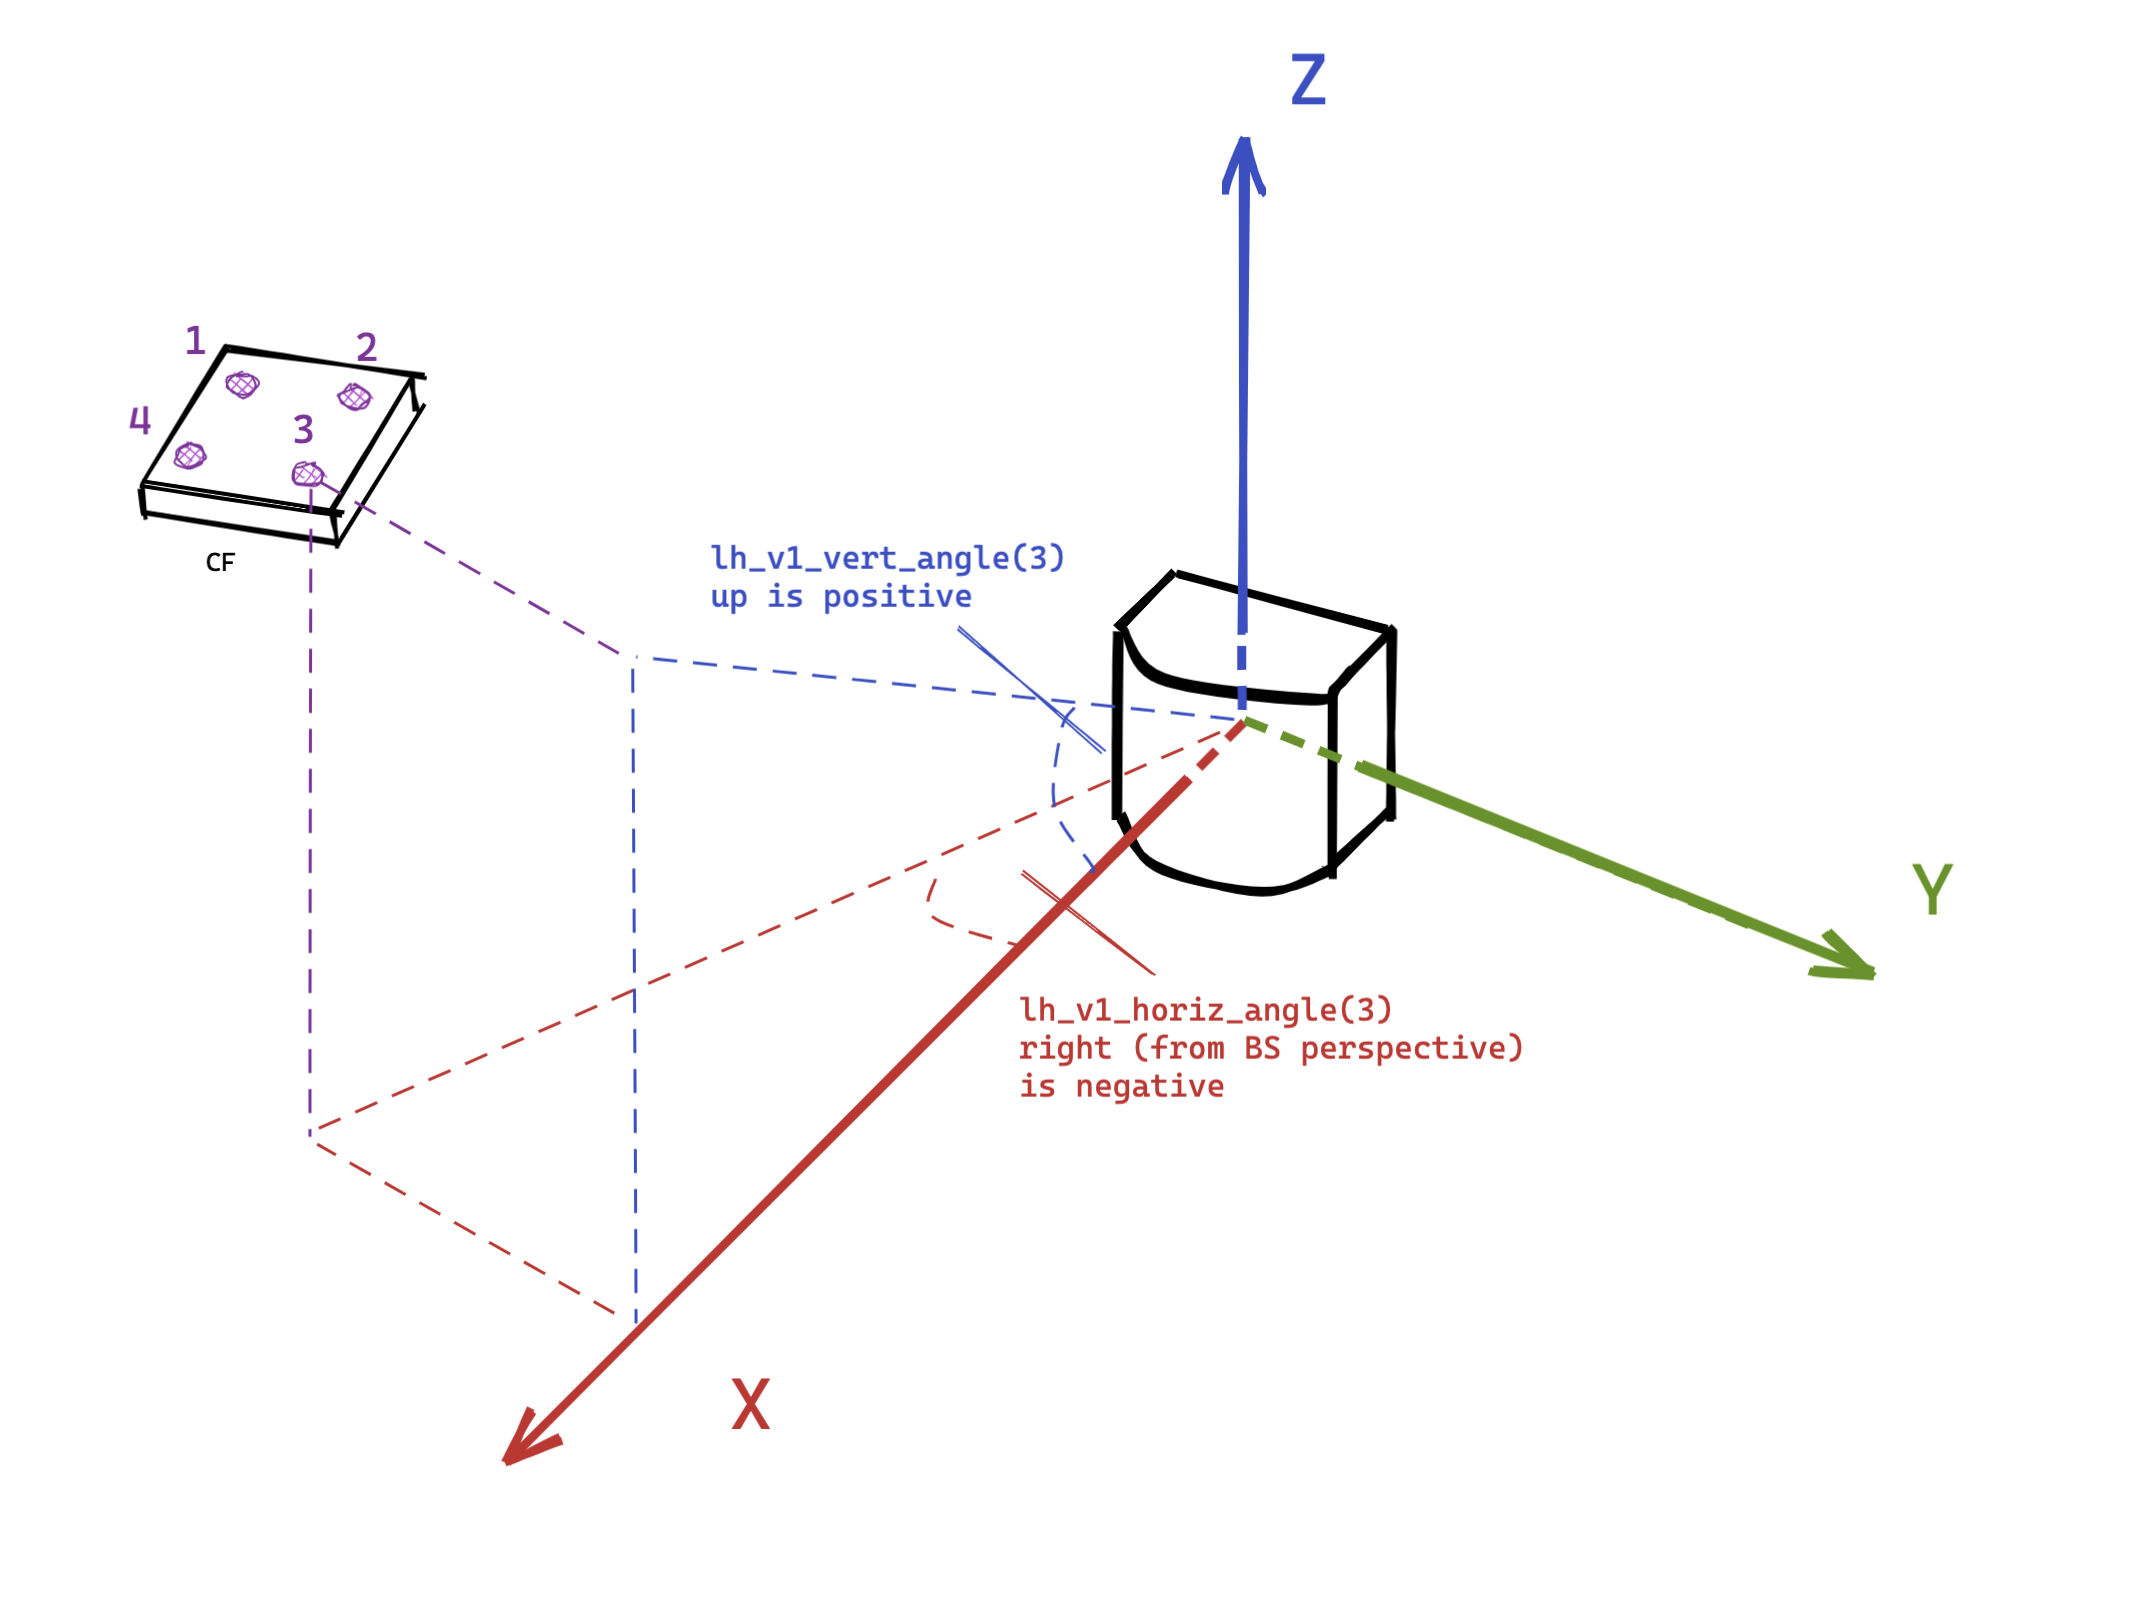
    
    
#### (2) For each base station, make an initial guess of the CF-to-BS yaw angle
- The list of 4 vectors are passed to the `LighthouseBsGeoEstimator.estimate_geometry` method
- This method first makes an "initial yaw guess" using the `_find_initial_yaw_guess` method, where the yaw is the angle in the XY plane of the CF reference frame which the CF would need be be rotated such that it'd be pointing (roughly) at the BS




- This guess is based on using the order in which the sensors are hit by the horizontal sweep (e.g. 0 -> 3 -> 2 -> 1)
- Each unique order is mapped to a constant yaw angle in the `_directions` class attribute for `LighthouseBsGeoEstimator`
- This mapping assumes a particular orientation of the BS with respect to the CF, namely that (in the BS reference frame) the BS is above the CF, facing down.


#### Subsequent steps

`get_bs_geometry` then goes on to estimate the full pose (rotation and position) of the BS with respect to the CF.

I expect that at step (2) however, our solution is already wrong for the "CF in sideways position" scenario shown above, as we're breaking the fundamental assumption of both BS' being "above the CF and pointing down". 

#### Proposed solution

1. Pass a dictionary to `_find_initial_yaw_guess` which maps base stations to their floor-wise orientation, i.e. either below the CF facing up, or above the CF facing down
2. Work out a suitable mutation of `_directions` which will work for the "below the CF facing down" scenario
3. See what breaks next
